<a href="https://colab.research.google.com/github/het345/racingtasks/blob/main/F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formula 1 Grand Prix result prediction



Before begining the project we need to understand the history of F1 and the diffrent eras in which a certain driver or constructor dominated the whole grid. Here are some important eras of F1 after 2010.  

* 1994-2009 Schumacher (Scuderia Ferrari)
* 2007-2010 Alonso (Renault,Scuderia Ferrari)
* 2011-2013 Vettle (Redbull Racing)
* 2014-Present Hamilton (Mercedes-Benz)

F1 Constructors performance are largely dependent on the FIA techinical regulation for the season after the 2013 season new engine regulation were made (Hybrid era) Mercedes-Benz are most dominat team since followed bu Redbull Racing and Scuderia Ferrari. Rules are set to change for 2022 so whatever analysis made here will not apply for 2022 season and so far. only data after 2010 will be considered in the following analysis.

Hetansh D1-1 60009220063

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
import matplotlib.pyplot as plt
plt.style.use('default')

In [ ]:
results = pd.read_csv(r'/Users/hetan2/Desktop/Formula-1-Prediction-master/data/results.csv')
races = pd.read_csv(r'/Users/hetan2/Desktop/Formula-1-Prediction-master/data/races.csv')
quali = pd.read_csv(r'/Users/hetan2/Desktop/Formula-1-Prediction-master/data/qualifying.csv')
drivers = pd.read_csv(r'/Users/hetan2/Desktop/Formula-1-Prediction-master/data/drivers.csv')
constructors = pd.read_csv(r'/Users/hetan2/Desktop/Formula-1-Prediction-master/data/constructors.csv')
circuit = pd.read_csv(r'/Users/hetan2/Desktop/Formula-1-Prediction-master/data/circuits.csv')

In [ ]:
# Load the required libraries
import pandas as pd

# Merge the datasets
df1 = pd.merge(races, results, how='inner', on=['raceId'])
df2 = pd.merge(df1, quali, how='inner', on=['raceId', 'driverId', 'constructorId'])
df3 = pd.merge(df2, drivers, how='inner', on=['driverId'])
df4 = pd.merge(df3, constructors, how='inner', on=['constructorId'])
df4 = df4.drop('url_x', axis=1)
df5 = pd.merge(df4, circuit, how='inner', on=['circuitId'])

In [ ]:
#drop the columns which are not important
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap',
                 'q2','q3','milliseconds','q1'], axis=1)

Removing data before 2010 as that is less relevant due to different car structures and safety standards

In [ ]:
#considering data points from 2010
data = data[data['year']>=2010]

In [ ]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [ ]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [ ]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [ ]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [ ]:
# Reasons for DNF (did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3, 4, 20, 29, 31, 41, 68, 73, 81, 97, 82, 104, 107, 130, 137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3, 4, 20, 29, 31, 41, 68, 73, 81, 97, 82, 104, 107, 130, 137, 1] else 0)
data.drop(['forename', 'surname'], axis=1, inplace=True)

In [ ]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

Calculating the amount races drivers did not finish(dnf) and hence calculating the ratio and plotting a bar chart

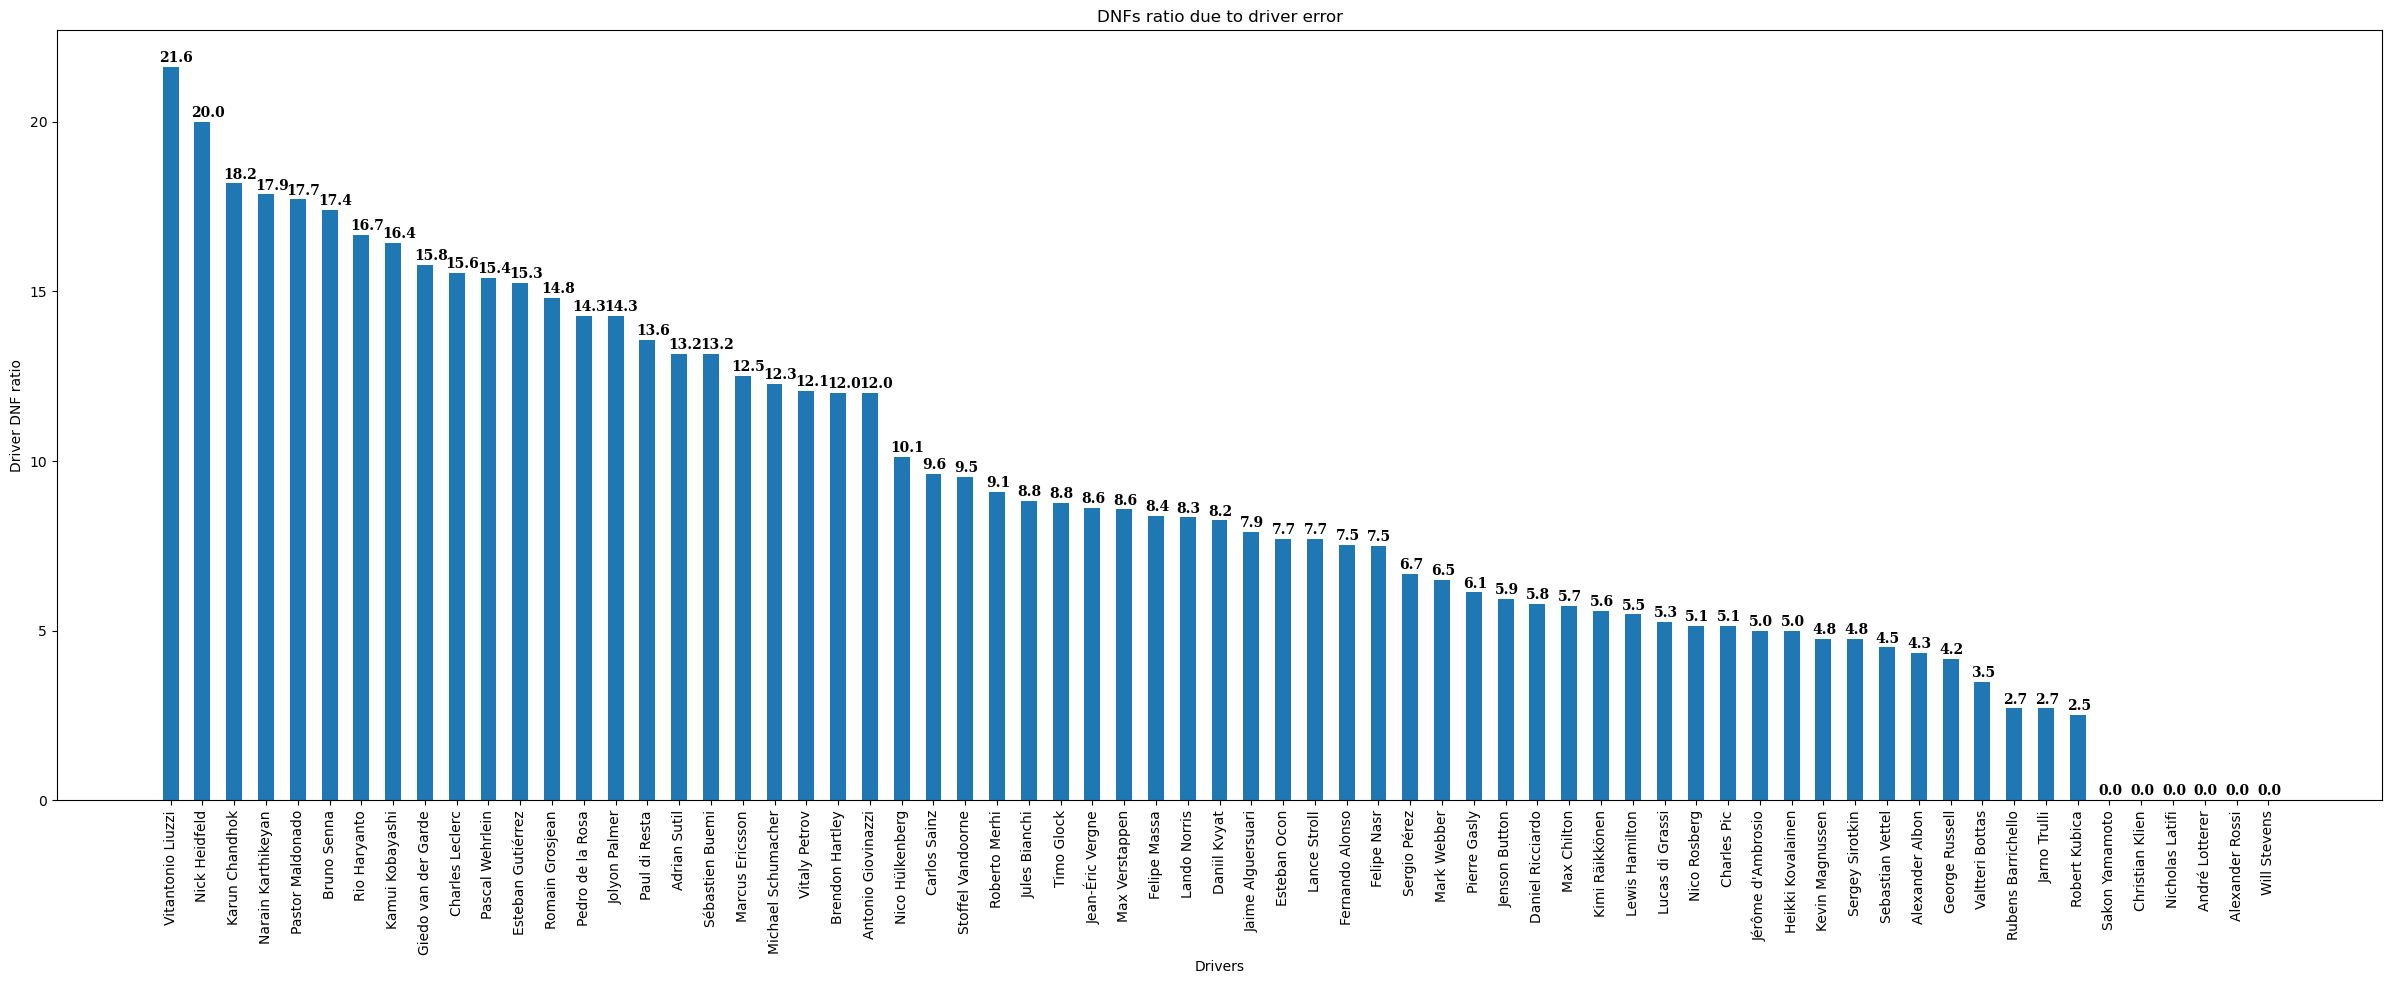

In [ ]:
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()
driver_race_entered = data.groupby('driver')['driver_dnf'].count()
driver_dnf_ratio = (dnf_by_driver * 100 / driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

Calculating the dnf ratio with respect to the team instead of the driver to calculate constructors

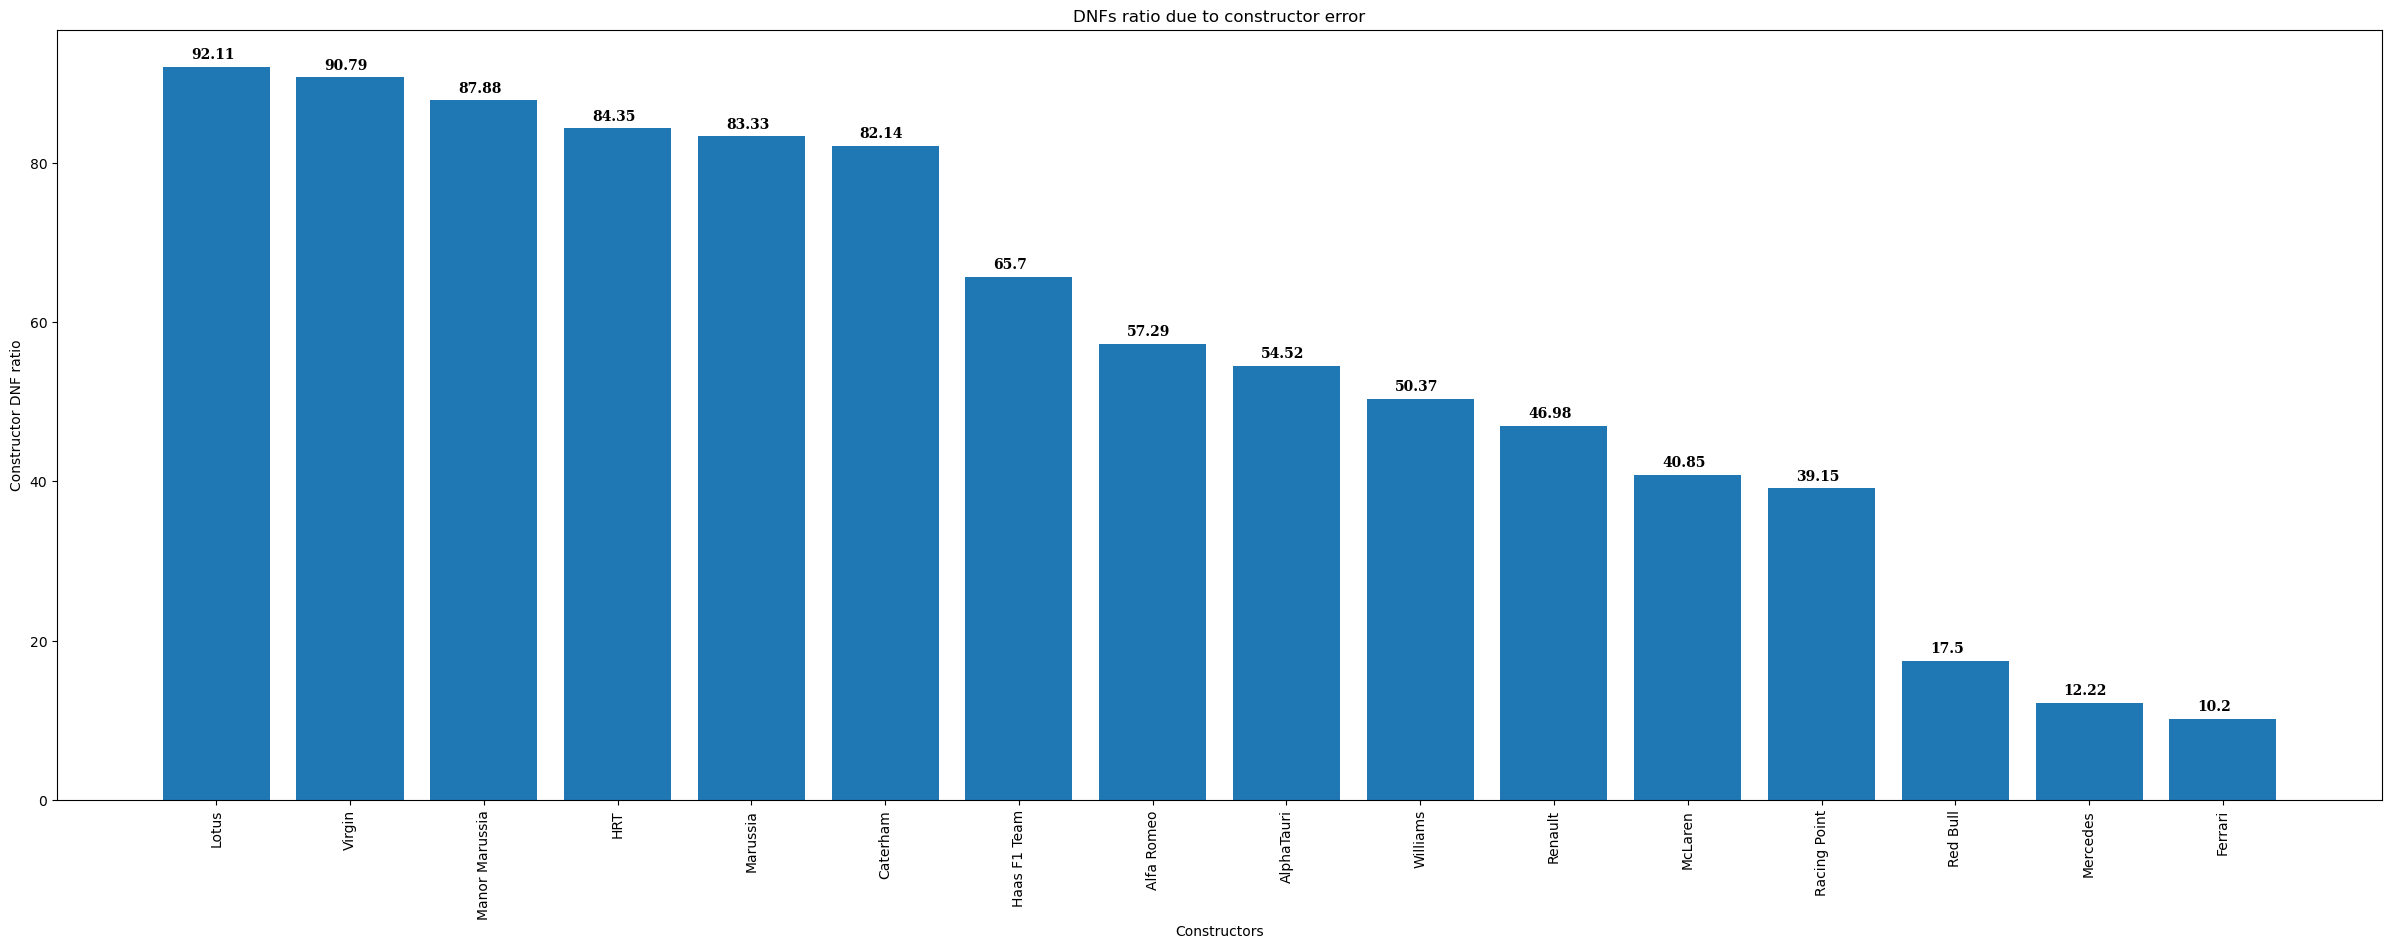

In [ ]:
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()
constructor_race_entered = data.groupby('constructor')['constructor_dnf'].count()
constructor_dnf_ratio = (dnf_by_constructor * 100 / constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF ratio')
plt.title('DNFs ratio due to constructor error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

Home race finish percent

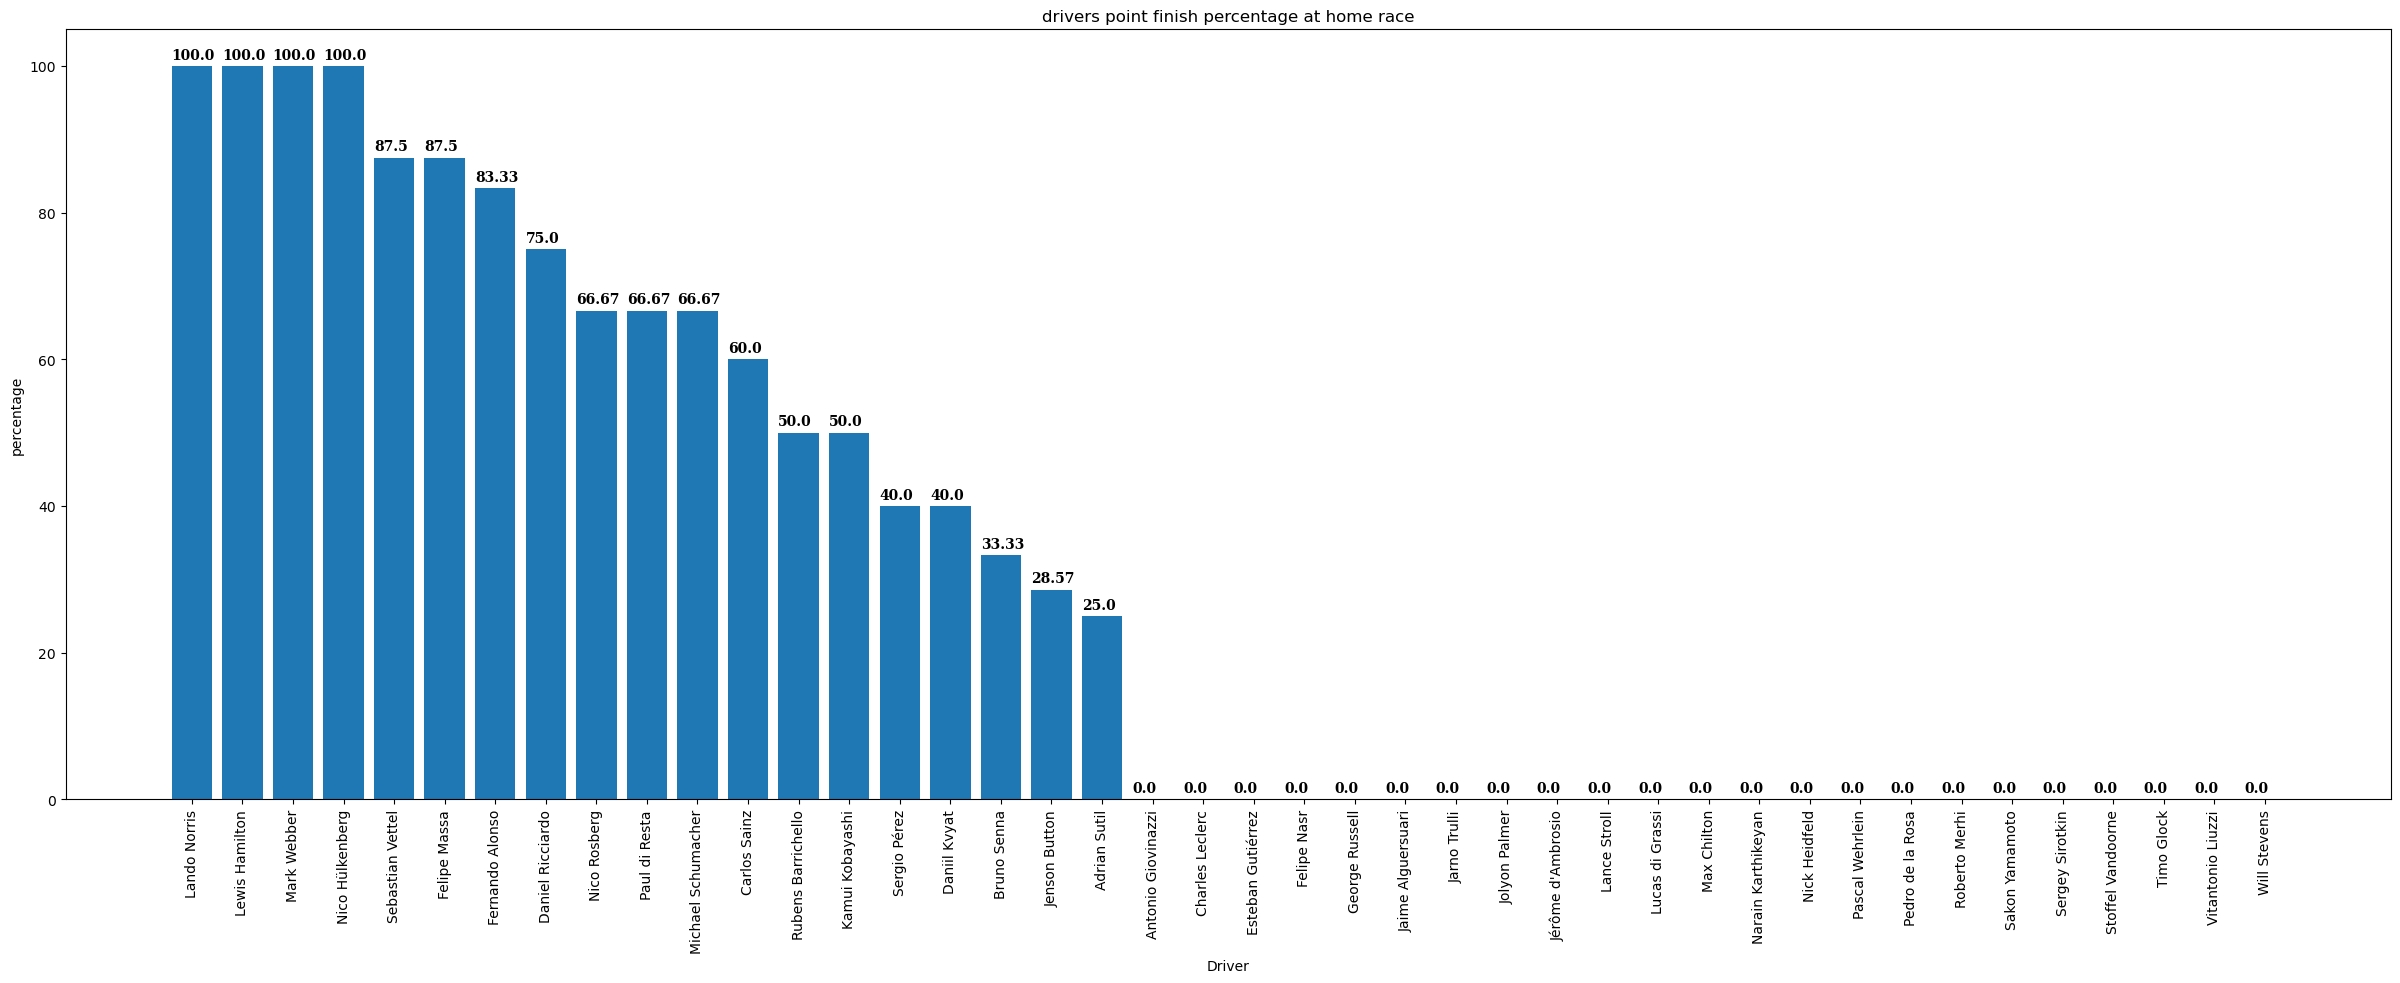

In [ ]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home'] == 1].groupby('driver')['driver_home'].sum()
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('percentage')
plt.title('drivers point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

Home podium finish

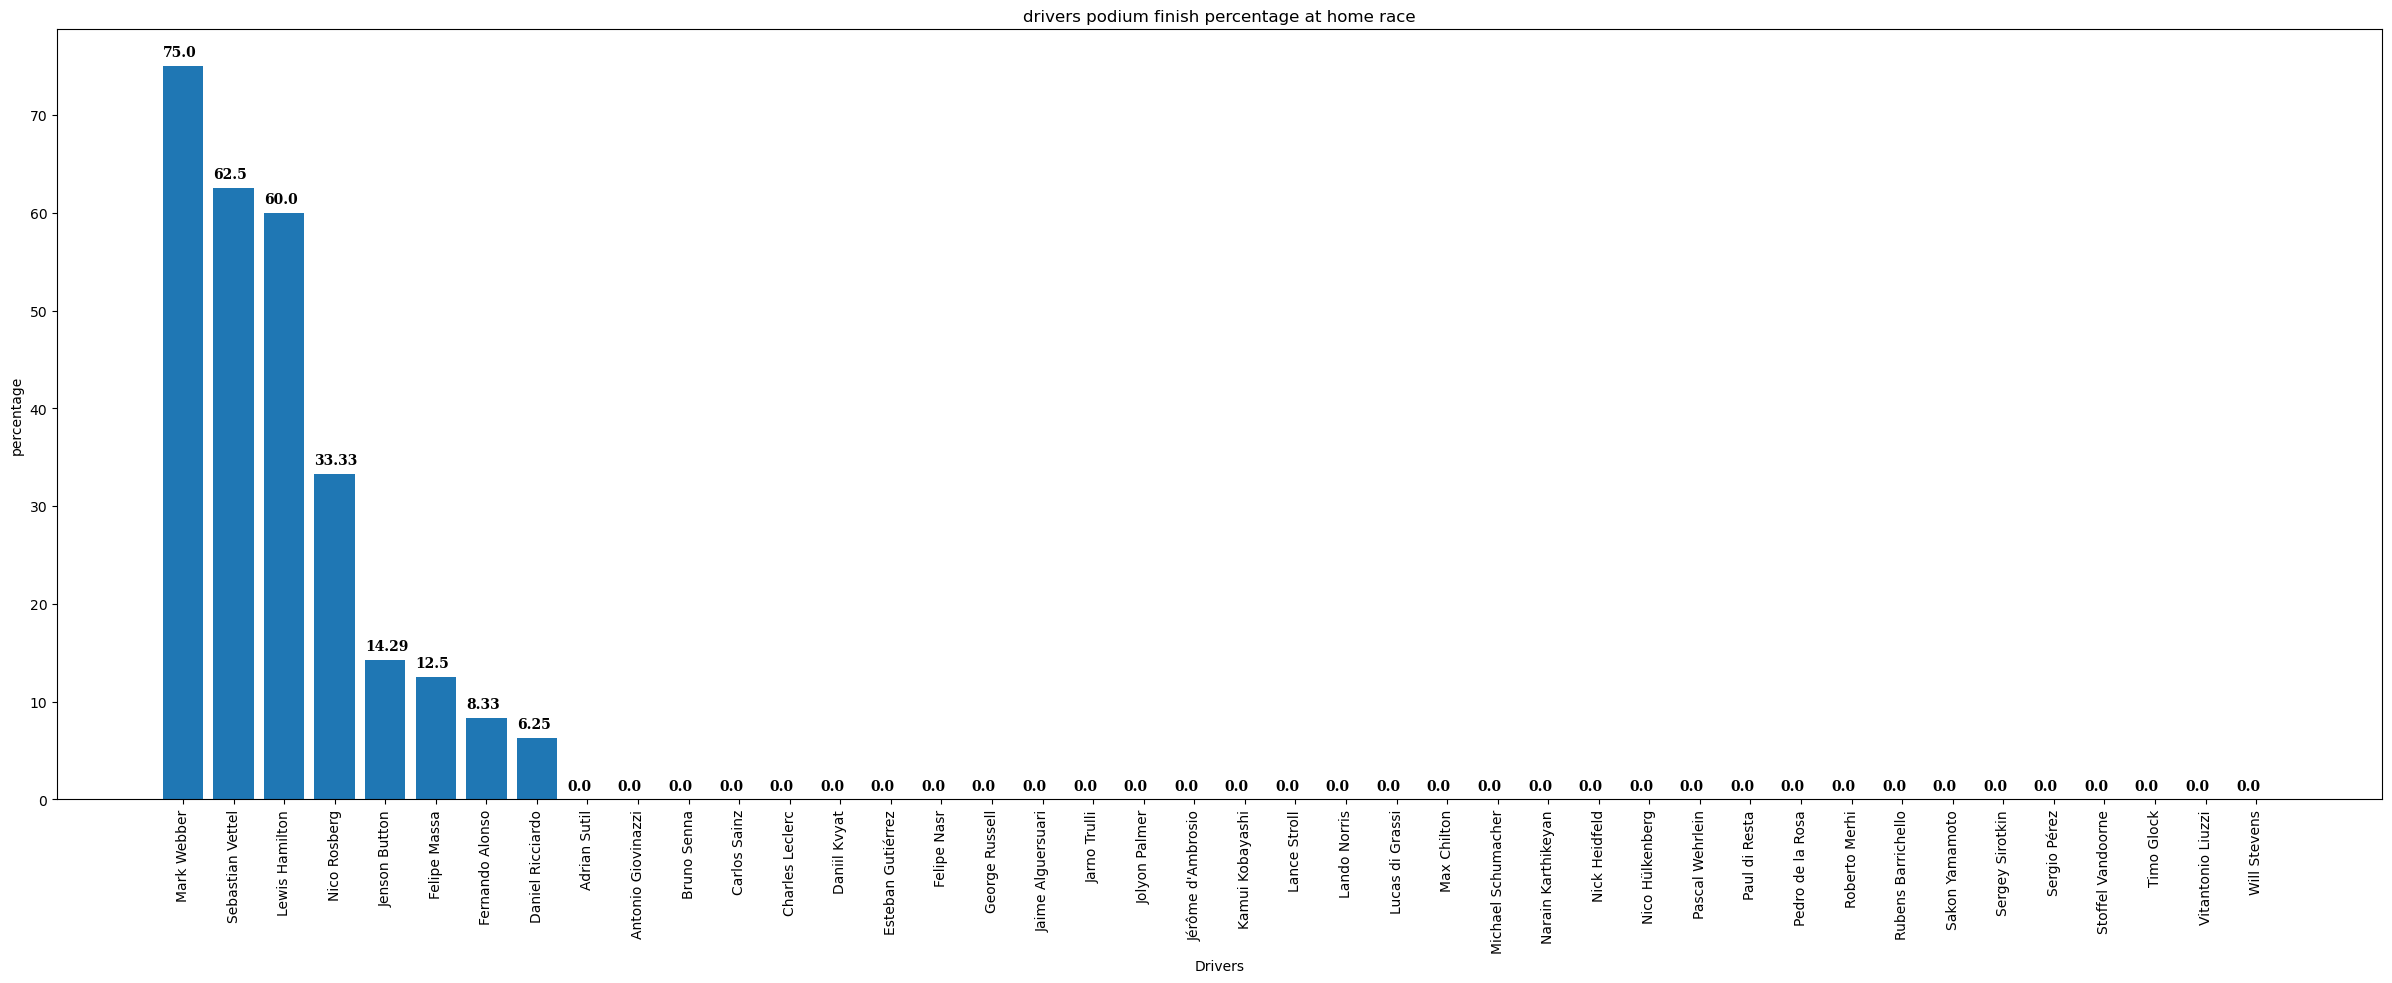

In [ ]:
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home'] == 1].groupby('driver')['driver_home'].sum()
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('drivers podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

Podium finish for teams

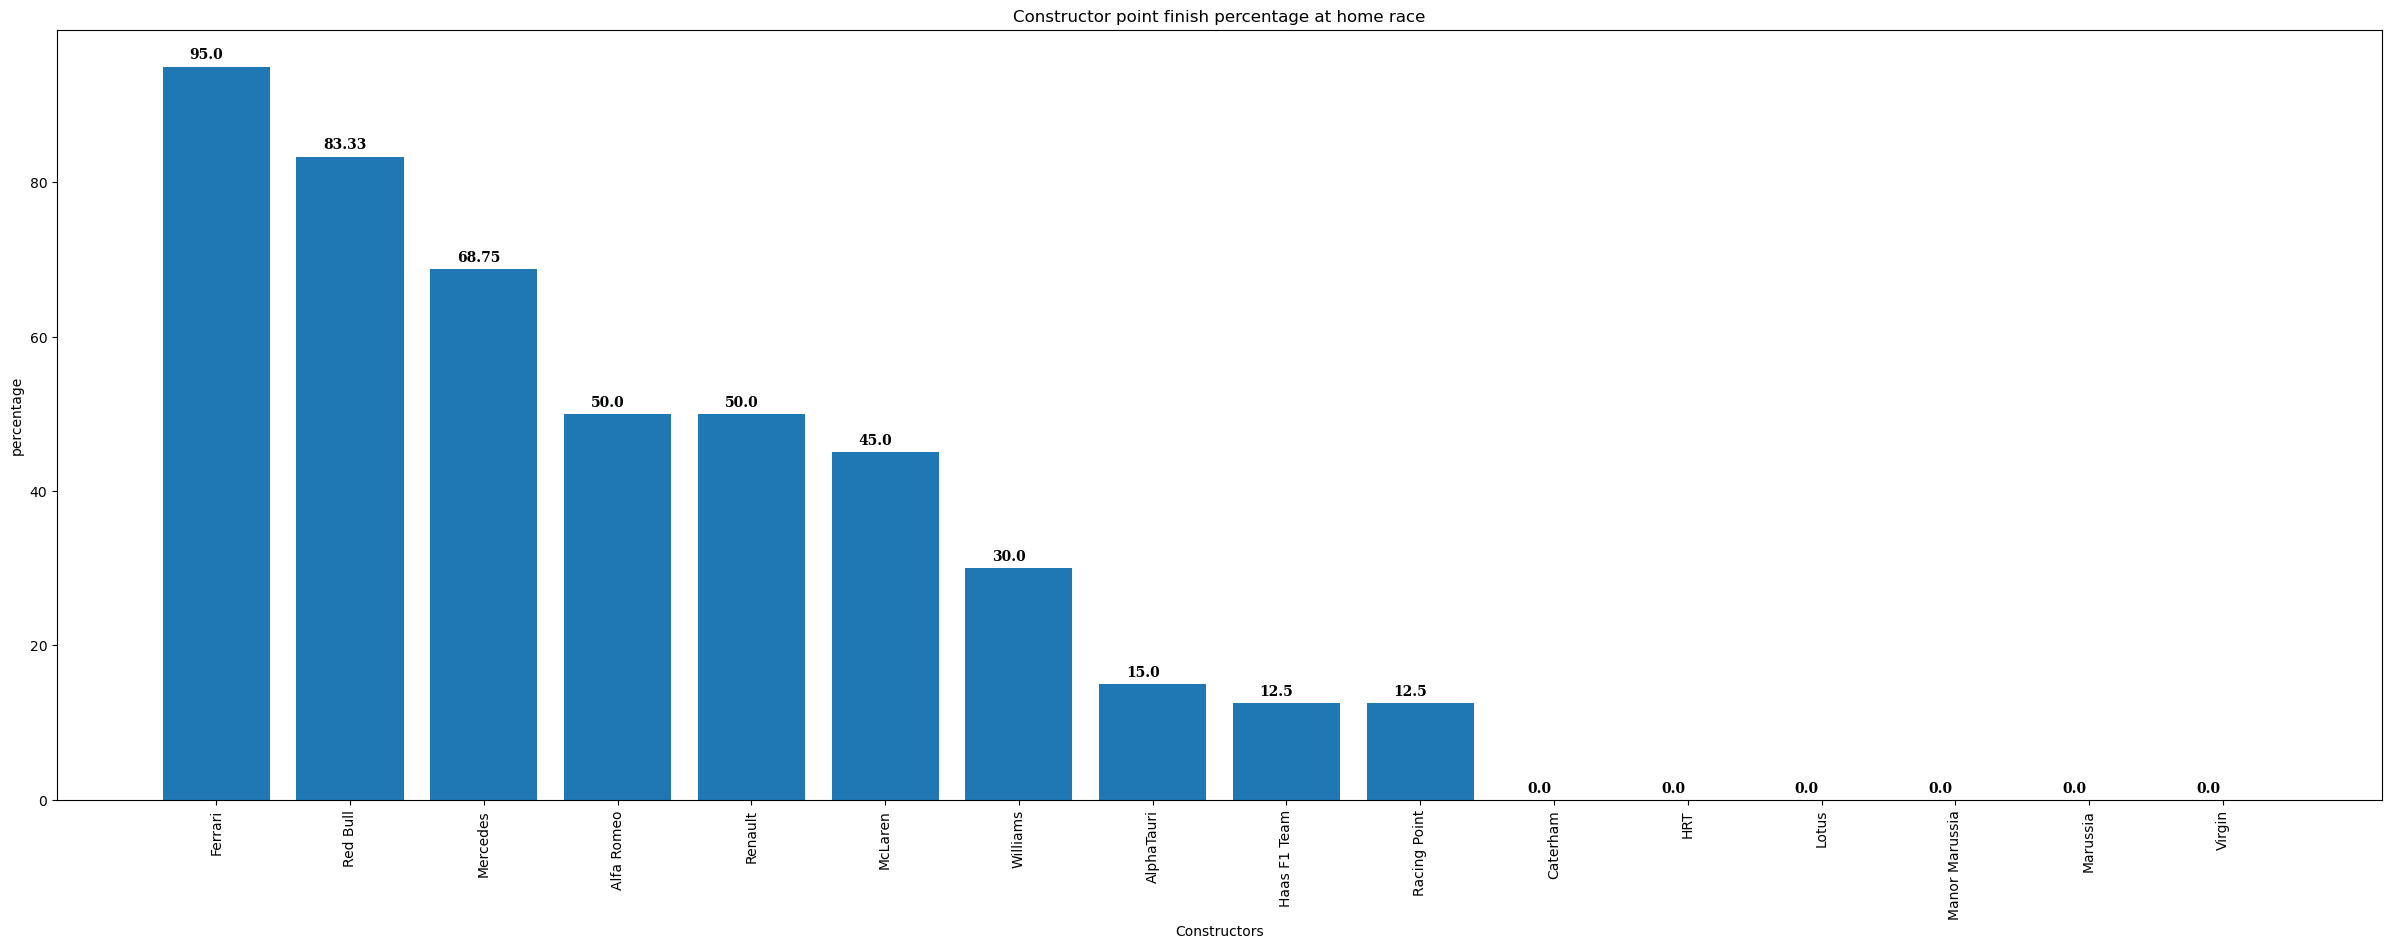

In [ ]:
# Exclude datetime columns from the sum operation
datetime_columns = data.select_dtypes(include=['datetime64']).columns
data_for_sum = data.drop(columns=datetime_columns)

# Perform the sum operation on the remaining columns
total_home_races = data_for_sum[data_for_sum['constructor_home']==1].groupby('constructor').sum()['constructor_home']

# Continue with the rest of your code
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

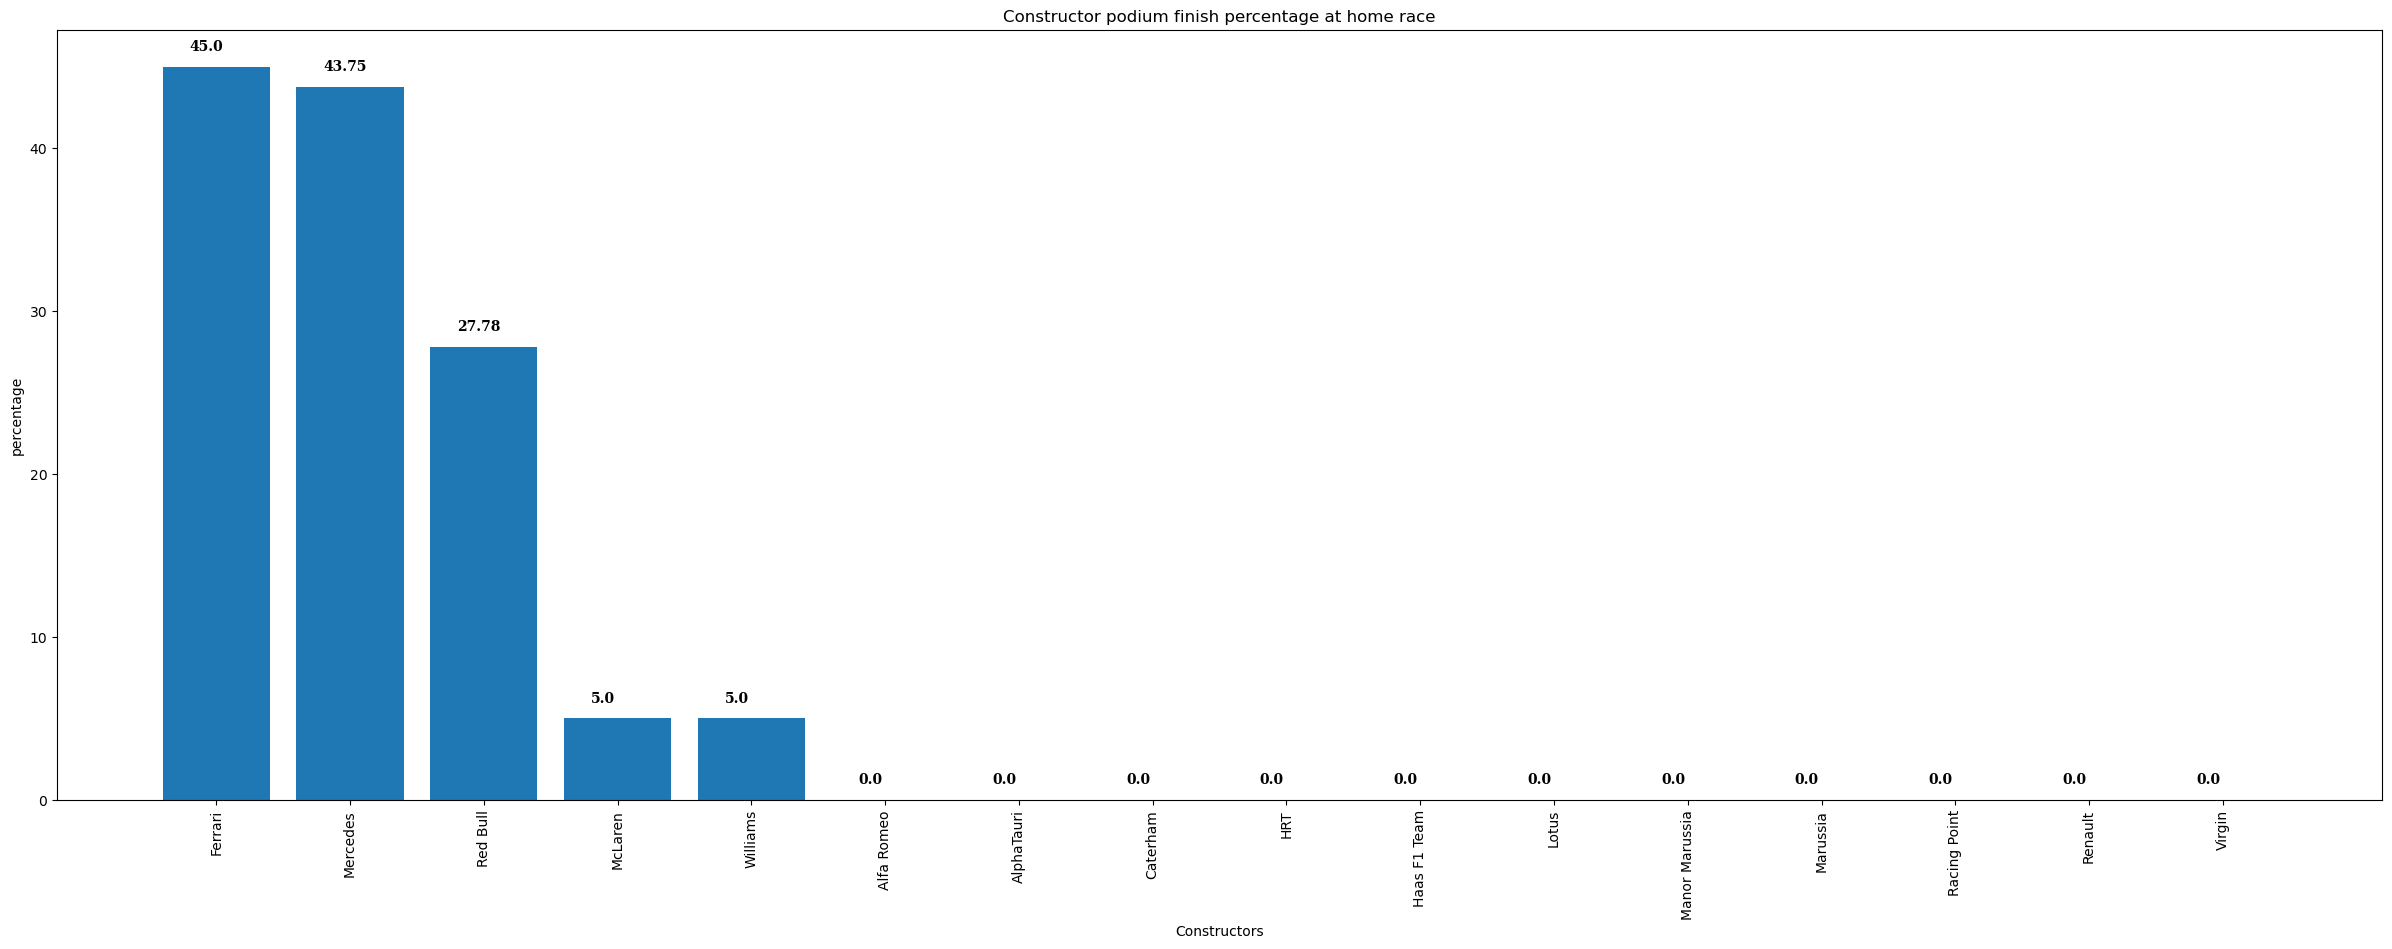

In [ ]:
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home'] == 1].groupby('constructor')['constructor_home'].sum()
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [ ]:
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()
driver_race_entered = data.groupby('driver')['driver_dnf'].count()
driver_dnf_ratio = (dnf_by_driver / driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [ ]:
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()
constructor_race_entered = data.groupby('constructor')['constructor_dnf'].count()
constructor_dnf_ratio = (dnf_by_constructor / constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

In [ ]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])
#removing retired drivers and constructors
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [ ]:
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
#cleaned_data.to_csv('cleaned_data.csv',index=False)

In [ ]:

cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob
39,Albert Park Grand Prix Circuit,12,Renault,Daniel Ricciardo,12,0.942197,0.530151,1,1,1989-07-01
40,Albert Park Grand Prix Circuit,14,Renault,Kevin Magnussen,15,0.952381,0.530151,1,1,1992-10-05
41,Albert Park Grand Prix Circuit,9,Renault,Carlos Sainz,9,0.903846,0.530151,1,1,1994-09-01
90,Albert Park Grand Prix Circuit,16,Williams,Valtteri Bottas,16,0.965035,0.496259,1,1,1989-08-28
91,Albert Park Grand Prix Circuit,15,Williams,Valtteri Bottas,10,0.965035,0.496259,1,1,1989-08-28
...,...,...,...,...,...,...,...,...,...,...
8122,Buddh International Circuit,1,Red Bull,Sebastian Vettel,1,0.955000,0.825000,1,1,1987-07-03
8123,Buddh International Circuit,7,Renault,Kimi Räikkönen,7,0.944099,0.530151,1,1,1979-10-17
8124,Buddh International Circuit,6,Renault,Kimi Räikkönen,6,0.944099,0.530151,1,1,1979-10-17
8125,Buddh International Circuit,11,Renault,Romain Grosjean,11,0.851852,0.530151,1,1,1986-04-17


In [ ]:

x = cleaned_data

In [ ]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [ ]:

data.columns

Index(['year', 'date', 'quali_pos', 'statusId', 'position', 'dob',
       'driver_nationality', 'constructor', 'constructor_nationality',
       'GP_name', 'country', 'driver', 'age_at_gp_in_days', 'driver_home',
       'constructor_home', 'driver_dnf', 'constructor_dnf',
       'driver_confidence', 'constructor_relaiblity', 'active_driver',
       'active_constructor'],
      dtype='object')

In [ ]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Aston Martin' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Alpine' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [ ]:
constructor_names = ['Ferrari', 'Red Bull', 'Mercedes', 'Racing Point', 'Williams', 'Alfa Romeo', 'AlphaTauri', 'McLaren', 'Renault', 'Haas F1 Team']

for name in constructor_names:
    reliability = cleaned_data.loc[cleaned_data['constructor'] == name, 'constructor_relaiblity'].values[0]
    print(f"{name}: {reliability}")

Ferrari: 0.8980099502487562
Red Bull: 0.825
Mercedes: 0.8778054862842892
Racing Point: 0.6084788029925188
Williams: 0.4962593516209476
Alfa Romeo: 0.42713567839195976
AlphaTauri: 0.4547738693467337
McLaren: 0.5914786967418546
Renault: 0.5301507537688442
Haas F1 Team: 0.34302325581395354


In [ ]:
drivers = [
    'Lewis Hamilton',
    'George Russell',
    'Max Verstappen',
    'Sergio Pérez',
    'Charles Leclerc',
    'Carlos Sainz',
    'Lando Norris',
    'Oscar Piastri',
    'Esteban Ocon',
    'Pierre Gasly',
    'Yuki Tsunoda',
    'Nyck de Vries',
    'Fernando Alonso',
    'Lance Stroll',
    'Valtteri Bottas',
    'Zhou Guanyu',
    'Alex Albon',
    'Logan Sargeant',
    'Kevin Magnussen',
    'Nico Hulkenberg'
]

driver_confidence_dict = {}

for driver in drivers:
    driver_data = cleaned_data[cleaned_data['driver'] == driver]
    if len(driver_data) > 0:
        driver_confidence_dict[driver] = driver_data.iloc[0]['driver_confidence']
    else:
        driver_confidence_dict[driver] = 0.8

for driver, confidence in driver_confidence_dict.items():
    print(f"{driver}: {confidence}")

Lewis Hamilton: 0.945273631840796
George Russell: 0.9583333333333334
Max Verstappen: 0.9142857142857143
Sergio Pérez: 0.9333333333333333
Charles Leclerc: 0.8444444444444444
Carlos Sainz: 0.9038461538461539
Lando Norris: 0.9166666666666666
Oscar Piastri: 0.8
Esteban Ocon: 0.9230769230769231
Pierre Gasly: 0.9387755102040817
Yuki Tsunoda: 0.8
Nyck de Vries: 0.8
Fernando Alonso: 0.8
Lance Stroll: 0.9230769230769231
Valtteri Bottas: 0.965034965034965
Zhou Guanyu: 0.8
Alex Albon: 0.8
Logan Sargeant: 0.8
Kevin Magnussen: 0.9523809523809523
Nico Hulkenberg: 0.8


In [ ]:
cleaned_data['istest'] = 0

In [ ]:

cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest
39,Albert Park Grand Prix Circuit,12,Renault,Daniel Ricciardo,12,0.942197,0.530151,1,1,1989-07-01,0
40,Albert Park Grand Prix Circuit,14,Renault,Kevin Magnussen,15,0.952381,0.530151,1,1,1992-10-05,0
41,Albert Park Grand Prix Circuit,9,Renault,Carlos Sainz,9,0.903846,0.530151,1,1,1994-09-01,0
90,Albert Park Grand Prix Circuit,16,Williams,Valtteri Bottas,16,0.965035,0.496259,1,1,1989-08-28,0
91,Albert Park Grand Prix Circuit,15,Williams,Valtteri Bottas,10,0.965035,0.496259,1,1,1989-08-28,0
...,...,...,...,...,...,...,...,...,...,...,...
8122,Buddh International Circuit,1,Red Bull,Sebastian Vettel,1,0.955000,0.825000,1,1,1987-07-03,0
8123,Buddh International Circuit,7,Renault,Kimi Räikkönen,7,0.944099,0.530151,1,1,1979-10-17,0
8124,Buddh International Circuit,6,Renault,Kimi Räikkönen,6,0.944099,0.530151,1,1,1979-10-17,0
8125,Buddh International Circuit,11,Renault,Romain Grosjean,11,0.851852,0.530151,1,1,1986-04-17,0


In [ ]:
constructors = ["Ferrari", "Red Bull", "Mercedes", "Racing Point", "Williams", "Alfa Romeo", "AlphaTauri", "McLaren",
                "Renault", "Haas F1 Team"]
driverconfidences = {"Lewis Hamilton": 0.9407114624505929, "George Russell": 0.9583333333333334,
                      "Max Verstappen": 0.9142857142857143, "Sergio Pérez": 0.9333333333333333,
                      "Charles Leclerc": 0.8444444444444444, "Carlos Sainz": 0.9038461538461539,
                      "Lando Norris": 0.9166666666666666, "Oscar Piastri": 0.8, "Esteban Ocon": 0.9230769230769231,
                      "Pierre Gasly": 0.9387755102040817, "Yuki Tsunoda": 0.8, "Nyck de Vries": 0.8,
                      "Fernando Alonso": 0.8, "Lance Stroll": 0.9230769230769231,
                      "Valtteri Bottas": 0.965034965034965, "Zhou Guanyu": 0.8, "Alex Albon": 0.8,
                      "Logan Sargeant": 0.8, "Kevin Magnussen": 0.9523809523809523, "Nico Hülkenberg": 0.8}
driver_confidences = [0.8444444444444444, 0.9142857142857143, 0.9333333333333333, 0.9038461538461539,
                      0.9407114624505929, 0.8, 0.9166666666666666, 0.8, 0.9230769230769231, 0.8,
                      0.9583333333333334, 0.9230769230769231, 0.8, 0.965034965034965, 0.8, 0.8,
                      0.8, 0.9523809523809523, 0.9387755102040817, 0.8]
drivers = ["Charles Leclerc", "Max Verstappen", "Sergio Pérez", "Carlos Sainz Jr.", "Lewis Hamilton", "Fernando Alonso","Lando Norris", "Yuki Tsunoda", "Lance Stroll", "Oscar Piastri", "George Russell", "Esteban Ocon","Alexander Albon", "Valtteri Bottas", "Logan Sargeant", "Zhou Guanyu", "Nico Hülkenberg", "Kevin Magnussen","Pierre Gasly", "Nyck de Vries"]

import random
constructor_reliabilities = [0.8243589743589743, 0.7508650519031141, 0.7508650519031141, 0.8243589743589743,
0.8778054862842892, 0.5902335456475584, 0.6344916344916345, 0.4553903345724907,
0.5902335456475584, 0.6344916344916345, 0.8778054862842892, 0.6018518518518519,
0.5699614890885751, 0.3952755905511811, 0.5699614890885751, 0.3952755905511811,
0.34302325581395354, 0.34302325581395354, 0.6018518518518519, 0.4553903345724907]
# Create dictionary of data
newdata = {
    'GP_name': ['Baku City Circuit'] * 20,
    'quali_pos': list(range(1, 21)),
    'constructor': ["Ferrari", "Red Bull","Red Bull","Ferrari","Mercedes","Racing Point","McLaren","AlphaTauri","Racing Point","McLaren", "Mercedes","Renault","Williams", "Alfa Romeo","Williams","Alfa Romeo","Haas F1 Team","Haas F1 Team","Renault","AlphaTauri"],
    'driver': drivers,
    'driver_confidence': driver_confidences,
    'constructor_relaiblity':constructor_reliabilities,
    'active_driver': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    'active_constructor': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    'constructor_home': [1] * 20,
    'dob': [1] * 20
}

# Create dataframe
new_data = pd.DataFrame(newdata)
new_data['istest'] = 1

# Print dataframe
new_data

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_relaiblity,active_driver,active_constructor,constructor_home,dob,istest
0,Baku City Circuit,1,Ferrari,Charles Leclerc,0.844444,0.824359,1,1,1,1,1
1,Baku City Circuit,2,Red Bull,Max Verstappen,0.914286,0.750865,1,1,1,1,1
2,Baku City Circuit,3,Red Bull,Sergio Pérez,0.933333,0.750865,1,1,1,1,1
3,Baku City Circuit,4,Ferrari,Carlos Sainz Jr.,0.903846,0.824359,1,1,1,1,1
4,Baku City Circuit,5,Mercedes,Lewis Hamilton,0.940711,0.877805,1,1,1,1,1
5,Baku City Circuit,6,Racing Point,Fernando Alonso,0.800000,0.590234,1,1,1,1,1
6,Baku City Circuit,7,McLaren,Lando Norris,0.916667,0.634492,1,1,1,1,1
7,Baku City Circuit,8,AlphaTauri,Yuki Tsunoda,0.800000,0.455390,1,1,1,1,1
8,Baku City Circuit,9,Racing Point,Lance Stroll,0.923077,0.590234,1,1,1,1,1
9,Baku City Circuit,10,McLaren,Oscar Piastri,0.800000,0.634492,1,1,1,1,1


In [ ]:
cleaned_data = pd.concat([cleaned_data,new_data])

In [ ]:
cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest,constructor_home
39,Albert Park Grand Prix Circuit,12,Renault,Daniel Ricciardo,12.0,0.942197,0.530151,1,1,1989-07-01 00:00:00,0,NaN
40,Albert Park Grand Prix Circuit,14,Renault,Kevin Magnussen,15.0,0.952381,0.530151,1,1,1992-10-05 00:00:00,0,NaN
41,Albert Park Grand Prix Circuit,9,Renault,Carlos Sainz,9.0,0.903846,0.530151,1,1,1994-09-01 00:00:00,0,NaN
90,Albert Park Grand Prix Circuit,16,Williams,Valtteri Bottas,16.0,0.965035,0.496259,1,1,1989-08-28 00:00:00,0,NaN
91,Albert Park Grand Prix Circuit,15,Williams,Valtteri Bottas,10.0,0.965035,0.496259,1,1,1989-08-28 00:00:00,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15,Baku City Circuit,16,Alfa Romeo,Zhou Guanyu,NaN,0.800000,0.395276,1,1,1,1,1.0
16,Baku City Circuit,17,Haas F1 Team,Nico Hülkenberg,NaN,0.800000,0.343023,1,1,1,1,1.0
17,Baku City Circuit,18,Haas F1 Team,Kevin Magnussen,NaN,0.952381,0.343023,1,1,1,1,1.0
18,Baku City Circuit,19,Renault,Pierre Gasly,NaN,0.938776,0.601852,1,1,1,1,1.0


In [ ]:
x

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest
39,Albert Park Grand Prix Circuit,12,Renault,Daniel Ricciardo,12,0.942197,0.530151,1,1,1989-07-01,0
40,Albert Park Grand Prix Circuit,14,Renault,Kevin Magnussen,15,0.952381,0.530151,1,1,1992-10-05,0
41,Albert Park Grand Prix Circuit,9,Renault,Carlos Sainz,9,0.903846,0.530151,1,1,1994-09-01,0
90,Albert Park Grand Prix Circuit,16,Williams,Valtteri Bottas,16,0.965035,0.496259,1,1,1989-08-28,0
91,Albert Park Grand Prix Circuit,15,Williams,Valtteri Bottas,10,0.965035,0.496259,1,1,1989-08-28,0
...,...,...,...,...,...,...,...,...,...,...,...
8122,Buddh International Circuit,1,Red Bull,Sebastian Vettel,1,0.955000,0.825000,1,1,1987-07-03,0
8123,Buddh International Circuit,7,Renault,Kimi Räikkönen,7,0.944099,0.530151,1,1,1979-10-17,0
8124,Buddh International Circuit,6,Renault,Kimi Räikkönen,6,0.944099,0.530151,1,1,1979-10-17,0
8125,Buddh International Circuit,11,Renault,Romain Grosjean,11,0.851852,0.530151,1,1,1986-04-17,0


In [ ]:
sc  = StandardScaler()
le = LabelEncoder()

x = cleaned_data
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position','active_driver','active_constructor'],axis=1)
X_test_new = X[X['istest'] == 1]
X = X[X['istest']== 0]
y = x[x['istest'] == 0]['position'].apply(lambda x: position_index(x))
#y = x[x['istest'] == 0]['position']

In [ ]:
X.dtypes

GP_name                     int64
quali_pos                   int64
constructor                 int64
driver                      int64
driver_confidence         float64
constructor_relaiblity    float64
istest                      int64
constructor_home          float64
dtype: object

In [ ]:
X = X.drop('dob', axis=1)
X_test_new =  X_test_new.drop('dob', axis=1)

In [ ]:

from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data and transform it
X_imputed = imputer.fit_transform(X)

# Perform cross-validation on the imputed data
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True)
    result = cross_val_score(model,X_imputed,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

LogisticRegression : 0.9073996113989639
DecisionTreeClassifier : 0.9074077072538861
RandomForestClassifier : 0.9292557210708118
SVC : 0.9240608808290156
GaussianNB : 0.8309234671848014
KNeighborsClassifier : 0.8881557642487046
